# Demand Forecasting (Pipeline & Modeling)

the objective of the model is to forecast the amount of qty_total for every item that should be available for the next week.


input:
- date: datetime --> predict on date
- B1G1: Bool --> Will there be a B1G1 promo?
- FS: Bool --> Will there be a FS promo
- menu_group: String  --> predicted menu

output: amount of qty should be availble for that week

In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

from bayes_opt import BayesianOptimization

## Load Data

In [59]:
FOLDER_PATH = '/Users/louisn/Documents/Legit-DS/Selection/demand-forecasting/data/'
DATA_PATH = FOLDER_PATH + 'interview-test.csv'

In [60]:
df = pd.read_csv(DATA_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8902 entries, 0 to 8901
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   salesdate   8902 non-null   object
 1   menuid      8902 non-null   int64 
 2   menuname    8902 non-null   object
 3   package     8902 non-null   object
 4   salesNum    8902 non-null   int64 
 5   bomid       8902 non-null   int64 
 6   menu_group  8902 non-null   object
 7   qty_total   8902 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 556.5+ KB


## Preprocessing

In [61]:
df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
df.set_index('salesdate', inplace=True)

In [62]:
df.sample(1)

,menuid,menuname,package,salesNum,bomid,menu_group,qty_total
salesdate,,,,,,,
2023-03-08,540,Gyudon Aburi with Miso Mayo & Sambal Korek,Package Content,4795,88,Gyudon Aburi with Miso Mayo & Sambal Korek,1


In [63]:
# split train & test data
split_dt = "2023-02-28"

train = df.loc[:split_dt]
test = df.loc[split_dt:]
ratio = len(test) / (len(train)+len(test))

print(f"train : {len(train)}")
print(f"test : {len(test)}")
print(f"test ratio: {ratio}.2f")

train : 6881
test : 2221
test ratio: 0.24401230498791474.2f


In [320]:
def preprocess_input(df, menugroup):
    df = df[df['menu_group'] == menugroup].copy()
    # datetime preprocessing
    try:
        df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
    except:
        pass

    # check for FS and B1G1 Promos
    patternFs = r'\[(.*?)\]'
    df['FS'] = df['menuname'].str.contains(patternFs)

    # extract pattern B1G1
    patternB1g1 = r'(B1G1)'
    df['B1G1'] = df['menuname'].str.contains(patternB1g1)

    # drop unrelevant cols
    df.drop(columns=['menuid','package','menuname','salesNum','bomid'], axis=1, inplace=True)

    # pivot on weekdays
    df_weekly = df.resample('W').sum()
    df_weekly.rename(columns= {
        'FS': 'FS_total',
        'B1G1': 'B1G1_total'
    }, inplace=True)

    # feature engineerid week of month
    # df_weekly['day'] = df_weekly.index.weekday
    df_weekly['week'] = (df_weekly.index.day - 1) // 7 + 1
    df_new = pd.get_dummies(df_weekly, columns=['week'])

    # split X and Y
    y = df_new['qty_total'].copy()
    X = df_new.drop('qty_total', axis=1).copy()

    return df_new, X, y

In [323]:
df_preprocessed, X, y = preprocess_input(df, 'Gyudon Aburi with Miso Mayo & Sambal Korek')
df_preprocessed.head(10) 

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()


,qty_total,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-10-16,1,0,0,0,0,1,0,0
2022-10-23,7,0,0,0,0,0,1,0
2022-10-30,0,0,0,0,0,0,0,1
2022-11-06,1,1,0,1,0,0,0,0
2022-11-13,9,0,0,0,1,0,0,0
2022-11-20,7,0,0,0,0,1,0,0
2022-11-27,30,1,0,0,0,0,1,0
2022-12-04,0,0,0,1,0,0,0,0
2022-12-11,4,0,0,0,1,0,0,0


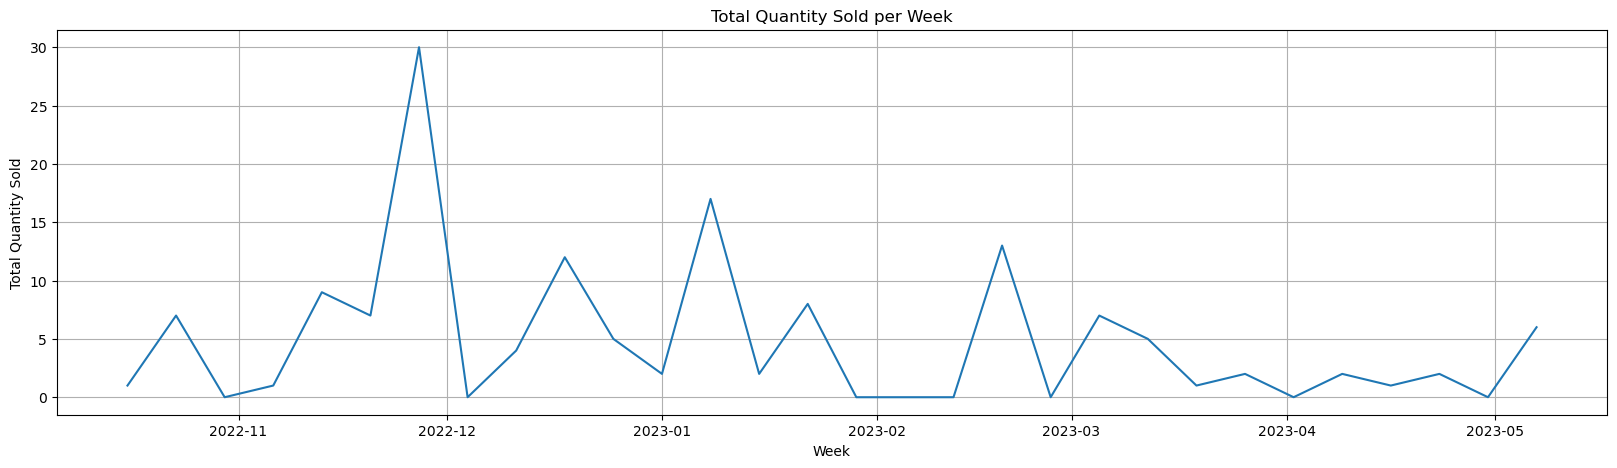

In [324]:
# Plot Graph
plt.figure(figsize=(20,5))
plt.plot(df_preprocessed.index, df_preprocessed['qty_total'])
plt.title('Total Quantity Sold per Week')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.show()

**Caution!: We could see that there are a seasonality pattern until 2023-01. This maybe caused because the sales haven't reached it's "stable state", so the model might be useful if there are already more data that exhibit seasonability, but until then we shall predict by using the train and test data that splitted on "2023-02-28"**

In [327]:
trainDf, trainX, trainY = preprocess_input(train,'Gyudon Aburi with Miso Mayo & Sambal Korek')
testDf, testX, testY = preprocess_input(test,'Gyudon Aburi with Miso Mayo & Sambal Korek')

print(f"trainX: {trainX.shape} | trainY: {trainY.shape}")
print(f"testX : {testX.shape} | testY : {testY.shape}")

trainX: (21, 7) | trainY: (21,)
testX : (10, 7) | testY : (10,)


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

In [328]:
# Scaling model to be passed to modeling 
scaler = MinMaxScaler()

trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)

## Modeling

### XGBoost (MAE: 2.1800114929676058)

XGBoost could be usable because it's capability to do multivariate forecasting and it's commmonly known for its effectiveness.

In [329]:
import xgboost as xgb

In [330]:
# Convert data into DMatrix format for XGBoost Multivariate
dTrain = xgb.DMatrix(data=trainX, label=trainY)
dTest =xgb.DMatrix(data=testX)

# XGBoost Parameter
params = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 3,
    'learning_rate': 0.1,
}

# train 
model = xgb.train(params, dTrain)

# predict
yPred = model.predict(dTest)

# evaluate
mae = mean_absolute_error(testY, yPred)

print(f"MAE: {np.mean(mae)}")

MAE: 2.1800114929676058


In [331]:
eval = testY.to_frame()
eval['pred'] = yPred
eval.head(12)

,qty_total,pred
salesdate,,
2023-03-05,3,1.489820
2023-03-12,5,4.259782
2023-03-19,1,4.259782
2023-03-26,2,4.259782
2023-04-02,0,1.489820
2023-04-09,2,4.259782
2023-04-16,1,4.259782
2023-04-23,2,4.259782
2023-04-30,0,0.250806


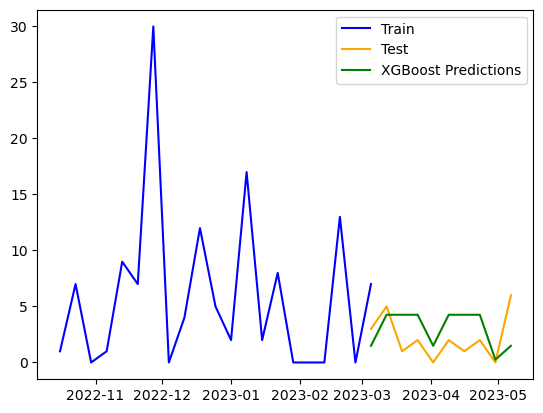

In [332]:
# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'XGBoost Predictions')
plt.legend()

#### Tuning

In [333]:
def black_box_XGBoost(eta, max_depth, learning_rate):
    # input params
    params = {
        'objective': 'reg:squarederror',
        'eta': eta,
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
    }

    # train 
    model = xgb.train(params, dTrain)

    # predict
    yPred = model.predict(dTest)

    # evaluate
    mae = mean_absolute_error(testY, yPred)

    return -mae

In [334]:
param_bounds = {
    'eta': (0.01, 0.3),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.1),
}

optimizer = BayesianOptimization(
    f=black_box_XGBoost,
    pbounds=param_bounds,
    random_state=1,
)

In [335]:
optimizer.maximize(
    init_points=3, 
    n_iter=100, 
)

|   iter    |  target   |    eta    | learni... | max_depth |
-------------------------------------------------------------
| 1         | -1.939    | 0.1309    | 0.07483   | 3.001     |
| 2         | -1.426    | 0.09768   | 0.02321   | 3.646     |
| 3         | -1.485    | 0.06402   | 0.0411    | 5.777     |
| 4         | -1.371    | 0.09932   | 0.03145   | 3.648     |
| 5         | -2.092    | 0.111     | 0.09005   | 3.656     |
| 6         | -1.36     | 0.1311    | 0.03079   | 3.64      |
| 7         | -1.418    | 0.07598   | 0.024     | 9.631     |
| 8         | -1.513    | 0.06839   | 0.01539   | 9.629     |
| 9         | -1.568    | 0.1464    | 0.04811   | 6.303     |
| 10        | -1.477    | 0.1295    | 0.01857   | 3.678     |
| 11        | -1.948    | 0.1517    | 0.08571   | 9.853     |
| 12        | -1.897    | 0.1035    | 0.07872   | 8.999     |
| 13        | -1.858    | 0.2579    | 0.07474   | 9.384     |
| 14        | -1.558    | 0.05775   | 0.04649   | 5.785     |
| 15    

In [336]:
best_hyperparameters = optimizer.max['params']
best_hyperparameters

{'eta': 0.07420164041035142,
 'learning_rate': 0.03011905584360771,
 'max_depth': 3.5525935873054095}

MAE: 2.1800114929676058


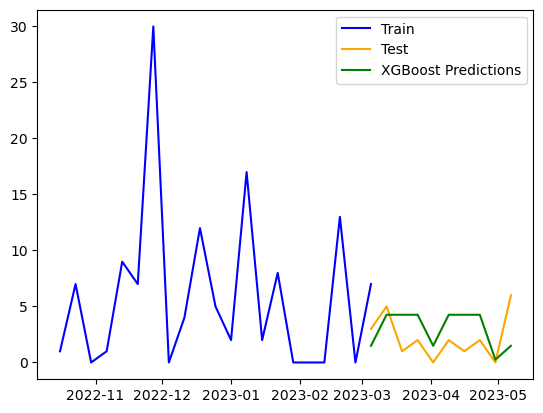

In [338]:
# XGBoost Parameter
params = {
    'objective': 'reg:squarederror',
    'eta': 0.01,
    'max_depth': 3,
    'learning_rate': 0.1,
}

# train 
model = xgb.train(params, dTrain)

# predict
yPred = model.predict(dTest)

# evaluate
mae = mean_absolute_error(testY, yPred)

print(f"MAE: {np.mean(mae)}")

eval = testY.to_frame()
eval['pred'] = yPred
eval.head(12)

# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'XGBoost Predictions')
plt.legend()

### VARMA (still error)

VARMA is suitable for multiple variables that may have dependencies on each other. VARMA extends the concepts of ARIMA to multiple variable

In [339]:
trainDf.head()

,qty_total,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-10-16,1,0,0,0,0,1,0,0
2022-10-23,7,0,0,0,0,0,1,0
2022-10-30,0,0,0,0,0,0,0,1
2022-11-06,1,1,0,1,0,0,0,0
2022-11-13,9,0,0,0,1,0,0,0


In [340]:
# # VARMA params
# params = {
#     'p': 2,
#     'q': 1
# }

# # train
# model = sm.tsa.VARMAX(trainX_scaled, order=(params['p'], params['q']))
# results = model.fit()

# # predict
# forecast = results.forecast(steps=len(testY))

### VAR (MAE: 2.3877717974230728)

In [346]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [347]:
dfTrain_new = trainDf.rename({'qty_total':'y'}, axis=1)
dfTrain_new.head()

,y,FS_total,B1G1_total,week_1,week_2,week_3,week_4,week_5
salesdate,,,,,,,,
2022-10-16,1,0,0,0,0,1,0,0
2022-10-23,7,0,0,0,0,0,1,0
2022-10-30,0,0,0,0,0,0,0,1
2022-11-06,1,1,0,1,0,0,0,0
2022-11-13,9,0,0,0,1,0,0,0


In [349]:
# Params 
params = {
    'p':1
}

# VAR model
model = VAR(dfTrain_new)
model_fit = model.fit(params['p'])

# lag order
lag_order = model_fit.k_ar
print("Lag order selected:", lag_order)

# predict
n_steps = len(testY)
forecast = model_fit.forecast(model_fit.endog, steps=n_steps)
pred = forecast[:, 0]

# evaluate
mae = mean_absolute_error(testY, pred)

print(f"MAE: {np.mean(mae)}")

Lag order selected: 1
MAE: 3.840753514943411


In [351]:
eval = testY.to_frame()
eval['pred'] = pred
eval.head(12)

,qty_total,pred
salesdate,,
2023-03-05,3,3.760600
2023-03-12,5,9.575069
2023-03-19,1,8.844781
2023-03-26,2,2.202899
2023-04-02,0,3.744484
2023-04-09,2,8.850611
2023-04-16,1,8.373753
2023-04-23,2,5.159106
2023-04-30,0,3.332470


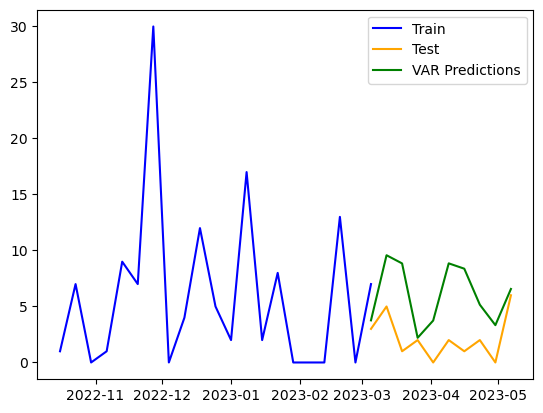

In [352]:
# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'VAR Predictions')
plt.legend()

#### Tuning

In [353]:
def black_box_VAR(p):

    try:
        # VAR model
        model = VAR(dfTrain_new)
        model_fit = model.fit(int(p))

        # lag order
        lag_order = model_fit.k_ar
        print("Lag order selected:", lag_order)

        # predict
        n_steps = len(testY)
        forecast = model_fit.forecast(model_fit.endog, steps=n_steps)
        pred = forecast[:, 0]

        # evaluate
        mae = mean_absolute_error(testY, pred)

        return -mae
    except:
        # error
        return 100

In [354]:
param_bounds = {
    'p':(1,10)
}

optimizer = BayesianOptimization(
    f=black_box_VAR,
    pbounds=param_bounds,
    random_state=1,
)

In [355]:
optimizer.maximize(
    init_points=3, 
    n_iter=20, 
)

|   iter    |  target   |     p     |
-------------------------------------
Lag order selected: 4
| 1         | -6.386    | 4.753     |
Lag order selected: 7
| 2         | -4.563    | 7.483     |
Lag order selected: 1
| 3         | -3.841    | 1.001     |
Lag order selected: 1
| 4         | -3.841    | 1.193     |
Lag order selected: 10
| 5         | -4.277    | 10.0      |
Lag order selected: 8
| 6         | -2.388    | 8.784     |
Lag order selected: 2
| 7         | -6.115    | 2.62      |
Lag order selected: 8
| 8         | -2.388    | 8.358     |
Lag order selected: 8
| 9         | -2.388    | 8.57      |
Lag order selected: 9
| 10        | -4.22     | 9.238     |
Lag order selected: 6
| 11        | -39.85    | 6.238     |
Lag order selected: 3
| 12        | -6.544    | 3.775     |
Lag order selected: 1
| 13        | -3.841    | 1.943     |
Lag order selected: 7
| 14        | -4.563    | 7.869     |
Lag order selected: 4
| 15        | -6.386    | 4.294     |
Lag order selected: 3
|

In [356]:
best_hyperparameters = optimizer.max['params']
best_hyperparameters

{'p': 8.783853889435717}

In [360]:
# Params 
params = {
    'p':8
}

# VAR model
model = VAR(dfTrain_new)
model_fit = model.fit(params['p'])

# lag order
lag_order = model_fit.k_ar
print("Lag order selected:", lag_order)

# predict
n_steps = len(testY)
forecast = model_fit.forecast(model_fit.endog, steps=n_steps)
pred = forecast[:, 0]

# evaluate
mae = mean_absolute_error(testY, pred)

print(f"MAE: {np.mean(mae)}")

Lag order selected: 8
MAE: 2.3877717974230728


In [361]:
eval = testY.to_frame()
eval['pred'] = pred
eval.head(12)

,qty_total,pred
salesdate,,
2023-03-05,3,-3.113697
2023-03-12,5,6.764224
2023-03-19,1,0.873636
2023-03-26,2,3.865309
2023-04-02,0,1.428750
2023-04-09,2,3.556461
2023-04-16,1,2.491020
2023-04-23,2,1.718465
2023-04-30,0,2.120378


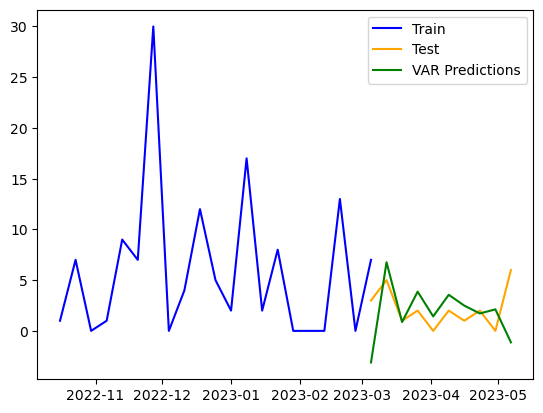

In [362]:
# plot 
plt.plot(trainY, color='blue', label = 'Train')
plt.plot(eval['qty_total'], color='orange', label = 'Test')
plt.plot(eval['pred'], color='green', label = 'VAR Predictions')
plt.legend()

## Deployment

**From this experiment, we did 2 the forecasting with VAR and XGBoost Model. Both experiment resulted promising result in the fornm of low MAE value**

however, we there are still other methods that can be done to be experimented on this experiment. some of it might be VECM, LSTM, RNN and other methods. Further data collection and grouping also might be needed to implement more robust model

In [392]:
MODEL_PATH = '/Users/louisn/Documents/Legit-DS/Selection/demand-forecasting/model'

In [393]:
def evaluate_model_XGB(df, menugroup):
    # set index
    try:
        df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
        df.set_index('salesdate', inplace=True)
    except:
        pass
    
    # split train & test data
    split_dt = "2023-02-28"

    train = df.loc[:split_dt]
    test = df.loc[split_dt:]
    
    train.dropna(inplace=True)
    test.dropna(inplace=True)

    _, trainX, trainY = preprocess_input(train,menugroup)
    _, testX, testY = preprocess_input(test,menugroup)

    # print(f"trainX: {trainX.shape} | trainY: {trainY.shape}")
    # print(f"testX : {testX.shape} | testY : {testY.shape}")

    # XGBoost Parameter
    params = {
        'objective': 'reg:squarederror',
        'eta': 0.01,
        'max_depth': 3,
        'learning_rate': 0.1,
    }

    # Convert data into DMatrix format for XGBoost Multivariate
    dTrain = xgb.DMatrix(data=trainX, label=trainY)
    dTest =xgb.DMatrix(data=testX)
    
    # train 
    model = xgb.train(params, dTrain)

    # predict
    yPred = model.predict(dTest)

    # evaluate
    mae = mean_absolute_error(testY, yPred)

    # print(f"MAE: {np.mean(mae)}")

    eval = testY.to_frame()
    eval['pred'] = yPred
    eval.head(12)

    # plot 
    # plt.plot(trainY, color='blue', label = 'Train')
    # plt.plot(eval['qty_total'], color='orange', label = 'Test')
    # plt.plot(eval['pred'], color='green', label = 'XGBoost Predictions')
    # plt.legend()

    return eval, mae, model


In [394]:
_, mae, _ = evaluate_model_XGB(df, 'Classic Mentega Chicken')
print('MAE: ', mae)

MAE:  1.792465799384647


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

In [395]:
menu_groups = df['menu_group'].unique()

for menu_group in menu_groups:
    path = MODEL_PATH + '/xgb/' + menu_group + '.xgb'
    try:
        _, mae, model = evaluate_model_XGB(df, menu_group)
        model.save_model(path)
        print(f"{menu_group} mae: {mae}")
    except:
        print(f"failed on {menu_group}")

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

0 mae: 70.46372556686401
failed on Spaghetti Prawn/Chicken Aglio Olio
failed on Teriyaki Gyudon
failed on Ninniku Gyudon
Extra Item mae: 4.217578689257304
failed on Spicy Gyudon
failed on Mentai Gyudon
failed on Black Pepper Chicken
Classic Mentega Chicken mae: 1.792465799384647
failed on Sei Sapi sambal rica
failed on Sei Ayam Belimbing Wuluh
failed on Korean Fried Chicken Wings
failed on Miso Gyudon
failed on Sei Sultan sambal andaliman
failed on Sei Sultan sambal rica
Crispy Cereal Chicken mae: 4.347965335845947
failed on Sei Sapi Premium Longboard
failed on Sei Sapi sambal matah
failed on Sei Ayam Longboard


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

failed on Sei Sultan sambal matah
failed on Sei Sapi sambal Embe
failed on Sei Ayam sambal andaliman
failed on Sei Ayam sambal matah
failed on Sei Sultan Belimbing Wuluh
failed on Sei Sapi sambal andaliman
failed on Spaghetti Chicken & Mushroom Crema
failed on Nasei Bungkus Ayam Padang
failed on Spaghetti with Truffle Cream and Chicken
failed on Kung Pao Chicken
Buttermilk Chicken mae: 1.9755876138806343
failed on Spaghetti Sausage Alfredo Junior
failed on Nachos with Cajun Sauce
failed on Korean Hot Sauce Chicken
failed on Classic Spaghetti Bolognese
failed on Bumbu Cabe Garam Chicken
Chicken Skin mae: 6.7917596906423565
failed on Chicken Dice Kungpao
Chicken Katsu Don mae: 8.46537671983242
failed on Spaghetti Spicy Seafood Mentai
failed on Spaghetti Samyang Carbonara
Gyudon Aburi with Miso Mayo & Sambal Korek mae: 2.1800114929676058
failed on Beef Gyudon Aburi
failed on Nasei Bungkus Sapi Padang
Sei Ayam Juicy mae: 1.872287521759669
failed on Caramelized Butter Chicken
failed on Sei 

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

In [398]:
def evaluate_model_VAR(df, menugroup):
    # set index
    try:
        df['salesdate'] = pd.to_datetime(df['salesdate'], format='%Y-%m-%d')
        df.set_index('salesdate', inplace=True)
    except:
        pass
    
    # split train & test data
    split_dt = "2023-02-28"

    train = df.loc[:split_dt]
    test = df.loc[split_dt:]
    
    train.dropna(inplace=True)
    test.dropna(inplace=True)

    dfTrain, _, _ = preprocess_input(train,menugroup)
    _, _, testY = preprocess_input(test,menugroup)

    # Params 
    params = {
        'p':8
    }

    # VAR model
    model = VAR(dfTrain)
    model_fit = model.fit(params['p'])

    # lag order
    lag_order = model_fit.k_ar
    # print("Lag order selected:", lag_order)

    # predict
    n_steps = len(testY)
    forecast = model_fit.forecast(model_fit.endog, steps=n_steps)
    pred = forecast[:, 0]

    # evaluate
    mae = mean_absolute_error(testY, pred)

    # print(f"MAE: {np.mean(mae)}")

    return eval, mae, model_fit


In [399]:
_, mae, _ = evaluate_model_VAR(df, 'Classic Mentega Chicken')
print('MAE: ', mae)

MAE:  2.9312634669461457


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

In [401]:
menu_groups = df['menu_group'].unique()

for menu_group in menu_groups:
    path = MODEL_PATH + '/var/' + menu_group + '.pkl'
    try:
        _, mae, model = evaluate_model_VAR(df, menu_group)
        model.save(path)
        print(f"{menu_group} mae: {mae}")
    except:
        print(f"failed on {menu_group}")

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

0 mae: 6543.127137754913
failed on Spaghetti Prawn/Chicken Aglio Olio
failed on Teriyaki Gyudon
failed on Ninniku Gyudon
Extra Item mae: 13.230849014161066
failed on Spicy Gyudon
failed on Mentai Gyudon
Black Pepper Chicken mae: 18.001183827648
Classic Mentega Chicken mae: 2.9312634669461457
failed on Sei Sapi sambal rica
failed on Sei Ayam Belimbing Wuluh
failed on Korean Fried Chicken Wings
failed on Miso Gyudon
failed on Sei Sultan sambal andaliman
failed on Sei Sultan sambal rica
Crispy Cereal Chicken mae: 31.478112592555146
failed on Sei Sapi Premium Longboard
failed on Sei Sapi sambal matah
failed on Sei Ayam Longboard
failed on Sei Sultan sambal matah
failed on Sei Sapi sambal Embe
failed on Sei Ayam sambal andaliman
failed on Sei Ayam sambal matah
failed on Sei Sultan Belimbing Wuluh


/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat

failed on Sei Sapi sambal andaliman
failed on Spaghetti Chicken & Mushroom Crema
failed on Nasei Bungkus Ayam Padang
failed on Spaghetti with Truffle Cream and Chicken
failed on Kung Pao Chicken
Buttermilk Chicken mae: 7.0398045940122485
failed on Spaghetti Sausage Alfredo Junior
Nachos with Cajun Sauce mae: 2.396899285620123
failed on Korean Hot Sauce Chicken
failed on Classic Spaghetti Bolognese
failed on Bumbu Cabe Garam Chicken
Chicken Skin mae: 9.680658270777464
failed on Chicken Dice Kungpao
Chicken Katsu Don mae: 69.44326428501708
Spaghetti Spicy Seafood Mentai mae: 5.3333333333333455
failed on Spaghetti Samyang Carbonara
Gyudon Aburi with Miso Mayo & Sambal Korek mae: 2.3877717974230728
failed on Beef Gyudon Aburi
Nasei Bungkus Sapi Padang mae: 44.84920143355971
Sei Ayam Juicy mae: 34.6856247996485
failed on Caramelized Butter Chicken
failed on Sei Sapi Belimbing Wuluh 
Nachos with Sambal mae: 1.2739448720664739
failed on Sweet and Spicy Chicken
failed on Spaghetti Chicken Sing

/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFs)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1g1)
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample('W').sum()
/var/folders/ts/znlzfqcx083c_s9fv3sc20rw0000gn/T/ipykernel_44282/1974202462.py:11: UserWarning: This pat